<a href="https://colab.research.google.com/github/jasmine1601/Sentiment-Analysis/blob/main/Sentiment_Analysis_using_simple_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load Dataset**

In [1]:
import numpy as np
import pandas as pd
import sklearn
df=pd.read_csv('/content/drive/MyDrive/ML/Datasets/Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [2]:
data = df[['airline_sentiment', 'text']]
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


**Data exploration**

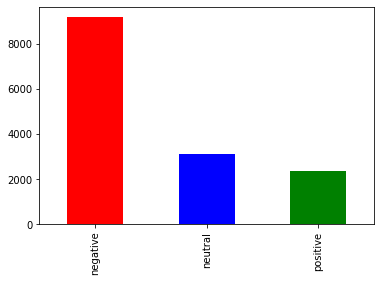

In [3]:
import matplotlib.pyplot as plt
data['airline_sentiment'].value_counts().sort_index().plot.bar(color=['red', 'blue', 'green'])

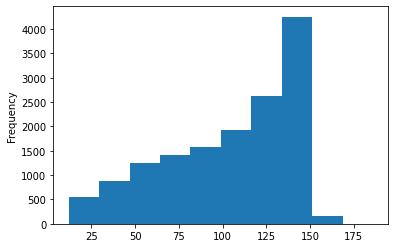

In [4]:
data['text'].str.len().plot.hist()

**Preprocessing data**

In [5]:
import warnings
warnings.filterwarnings('ignore')

data['text'] = data['text'].str.replace('@VirginAmerica', '')
data.head()

,airline_sentiment,text
0,neutral,What @dhepburn said.
1,positive,plus you've added commercials to the experien...
2,neutral,I didn't today... Must mean I need to take an...
3,negative,"it's really aggressive to blast obnoxious ""en..."
4,negative,and it's a really big bad thing about it


In [6]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
stop_words = stopwords.words('english')

In [8]:
len(stop_words)

179

In [9]:
negative_words=['no','not',"don't","aren't","couldn't","didn't","doesn't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","shouldn't","wasn't","weren't","won't","wouldn't"]
for negative_word in negative_words:
  stop_words.remove(negative_word)

len(stop_words)

160

In [10]:
import re             # re -> regular expressions

def clean_text(sample):
  sample = sample.lower()
  sample = sample.replace("<br /><br />", "")
  sample = re.sub("[^a-z]+", " ", sample)
  sample = sample.split(" ")
  sample = [word for word in sample if word not in stop_words ]
  sample = " ".join(sample)
  
  return sample


In [11]:
data['text'] = data['text'].apply(clean_text)
data.head()

,airline_sentiment,text
0,neutral,dhepburn said
1,positive,plus added commercials experience tacky
2,neutral,today must mean need take another trip
3,negative,really aggressive blast obnoxious entertainme...
4,negative,really big bad thing


**Tokenization**

In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, split=" ")
tokenizer.fit_on_texts(data['text'].values)

X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length

In [13]:
# pd.get_dummies: Convert categorical variable into dummy/indicator variables.
y = pd.get_dummies(data['airline_sentiment']).values
[print(data['airline_sentiment'][i], y[i]) for i in range(0,5)]

neutral [0 1 0]
positive [0 0 1]
neutral [0 1 0]
negative [1 0 0]
negative [1 0 0]


[None, None, None, None, None]

**Splitting the data**

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 0)

In [15]:
np.unique(y_train,return_counts=True)

(array([0, 1], dtype=uint8), array([23424, 11712]))

In [16]:
np.unique(y_test,return_counts=True)

(array([0, 1], dtype=uint8), array([5856, 2928]))

**RNN Model**

In [17]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import SimpleRNN
from keras.layers import Dense

# Embedding Layer: Turns positive integers (indexes) into dense vectors of fixed size.
# SimpleRNN Layer: Fully-connected RNN where the output is to be fed back to input.

text_model = Sequential()
text_model.add(Embedding(5000, 256, input_length=X.shape[1]))
text_model.add(SimpleRNN(X.shape[1]))
text_model.add(Dense(3,activation='softmax'))
print(text_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 23, 256)           1280000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 23)                6440      
_________________________________________________________________
dense (Dense)                (None, 3)                 72        
Total params: 1,286,512
Trainable params: 1,286,512
Non-trainable params: 0
_________________________________________________________________
None


**Compile Model**

In [18]:
text_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

**Train Model**

In [19]:
history = text_model.fit(X_train, y_train, epochs=5,batch_size=32)

Epoch 1/5
366/366 [==============================] - 9s 22ms/step - loss: 0.7658 - accuracy: 0.6763
Epoch 2/5
366/366 [==============================] - 8s 22ms/step - loss: 0.3500 - accuracy: 0.8745
Epoch 3/5
366/366 [==============================] - 8s 22ms/step - loss: 0.1885 - accuracy: 0.9388
Epoch 4/5
366/366 [==============================] - 8s 23ms/step - loss: 0.1017 - accuracy: 0.9707
Epoch 5/5
366/366 [==============================] - 8s 22ms/step - loss: 0.0742 - accuracy: 0.9783


**Model Evaluation**

In [20]:
scores = text_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 75.44%


**Model Testing**

In [21]:
predictions = text_model.predict(X_test)

In [22]:
[print(data['text'][4], predictions[4], y_test[4])]

 really big bad thing [0.8572945  0.00141995 0.1412856 ] [1 0 0]


[None]